In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
# load standard python modules

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn


seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)




device: cuda


# Load in the data + crop

In [2]:

path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"

sig_samp_id = "CWoLa_n_sig_25000_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/"
bkg_samp_id = "CWoLa_n_sig_0_n_bkg_25000_n_nonzero_50_n_pad_0_n_jet_2/"

TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_sig_data = path_to_save_dir+sig_samp_id
print(path_to_sig_data)
path_to_bkg_data = path_to_save_dir+bkg_samp_id
print(path_to_bkg_data)

path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


sig_data = np.load(path_to_sig_data+"data_train.npy")
sig_labels = np.load(path_to_bkg_data+"labels_train.npy")
bkg_data = np.load(path_to_bkg_data+"data_train.npy")
bkg_labels = np.load(path_to_bkg_data+"labels_train.npy")

STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")

n = 10000

# Crop the data, rescale pt
cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)[:n,:,:]
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)[:n,:,:]
sig_labels = sig_labels[:n]
bkg_labels = bkg_labels[:n]

cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Sig data shape: " + str( cropped_sig_data.shape ), flush=True)
print( "Sig labels shape: " + str( sig_labels.shape ), flush=True)
print( "Bkg data shape: " + str( cropped_bkg_data.shape ), flush=True)
print( "Sig data shape: " + str( bkg_labels.shape ), flush=True)

print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)


/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_25000_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_0_n_bkg_25000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
Sig data shape: (10000, 3, 100)
Sig labels shape: (10000,)
Bkg data shape: (10000, 3, 100)
Sig data shape: (10000,)
STS data shape: (20000, 3, 100)
STS labels shape: (20000,)


# Load in the transformer net

In [3]:
model_dim = 128

exp_id = "SB_ratios_22_18_01/0kS_16kB_"+str(model_dim)+"d/"


# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

# transformer hyperparams
# input dim to the transformer -> (pt,eta,phi)
input_dim = 3
output_dim = model_dim
dim_feedforward = model_dim
n_heads = 4
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.0001

# Loading in the final transformer

loaded_net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )
loaded_net.load_state_dict(torch.load(expt_dir+"final_model_"+str(n_constits_max)+".pt"))
loaded_net.to( device )
loaded_net.eval()



Transformer(
  (embedding): Linear(in_features=3, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128

# Send the data into the latent space

In [4]:

print("Loading data into net...")
sig_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_sig_data ).transpose(1,2), cropped_sig_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
bkg_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_bkg_data ).transpose(1,2), cropped_bkg_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()

STS_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_STS_data ).transpose(1,2), cropped_bkg_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()

print("Data loaded!")



Loading data into net...
Data loaded!


# Functions to generate mixed samples, then train-val-test splits

In [5]:
# Make mixed samples

def generate_mixed_sample(sig_set, bkg_set, f):
    
    """
    INPUTS
    f: signal fraction for sample 1
        -- by default, the signal fraction for sample 2 is 1 - f
    
    OUTPUTS
    M1_reps, M2_reps : shuffled array of [signal + background] samples
    """
    ((sig_M1, sig_M2),
     (bkg_M2, bkg_M1),) = [train_test_split(arr, test_size=(1-f)) for arr in [
                                                sig_set,
                                                bkg_set,]] 
    # concatenate the signal, background
    M1_reps = np.concatenate((sig_M1, bkg_M1))
    M2_reps = np.concatenate((sig_M2, bkg_M2))
    
    # shuffle
    M1_reps = shuffle(M1_reps)
    M2_reps = shuffle(M2_reps)
    
    return M1_reps, M2_reps

# Make the test - val - train splits

def generate_train_test_val(M1, M2, test_size = 0.0, val_size = 0.2):
    """
    INPUTS
    M1: np.array of data to be given the label 1
    M2: np.array of data to be given the label 0
    
    OUPUTS
    training, validation, and testing datasets + labels
    
    """
    """
    # split data into train-test
    ((M1_train, M1_test),
     (M2_train, M2_test),) = [train_test_split(arr, test_size=test_size) for arr in [
                                                M1,
                                               M2,]]

    """
    # split train data into train-val
    ((M1_train, M1_val),
     (M2_train, M2_val),) = [train_test_split(arr, test_size=val_size) for arr in [
                                                M1,
                                                M2,]]

    # prepare the datasets + labels
    data_train = np.concatenate((M1_train, M2_train))
    labels_train = np.concatenate([np.ones(M1_train.shape[0]),np.zeros(M2_train.shape[0])])
    data_train, labels_train = shuffle(data_train, labels_train)

    data_val = np.concatenate((M1_val, M2_val))
    labels_val = np.concatenate([np.ones(M1_val.shape[0]),np.zeros(M2_val.shape[0])])
    data_val, labels_val = shuffle(data_val, labels_val)
    
    """
    data_test = np.concatenate((M1_test, M2_test))
    labels_test = np.concatenate([np.ones(M1_test.shape[0]),np.zeros(M2_test.shape[0])])
    data_test, labels_test = shuffle(data_test, labels_test)
    """
    
    return data_train, labels_train, data_val, labels_val

    

# Testing the classifier (fully supervised)

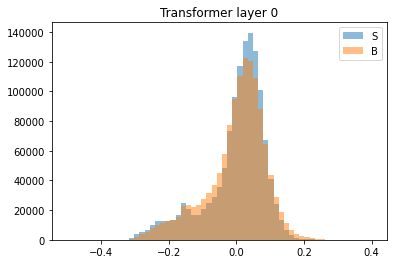

In [6]:
# Make the datasets


M1 = sig_reps
M2 = bkg_reps

layer = 0


S = np.reshape(M1[:,layer,:], (M1.shape[0]*M1.shape[2],1))
B = np.reshape(M2[:,layer,:], (M2.shape[0]*M2.shape[2],1))

bins = np.linspace(-.5,.4,60)

plt.figure()
plt.hist(S, bins, label = "S", alpha = 0.5)
plt.hist(B, bins, label = "B", alpha = 0.5)
plt.legend()
plt.title("Transformer layer "+str(layer))
plt.show()




Train data shape: (16000, 3, 128)
Train labels shape: (16000,)
Val data shape: (4000, 3, 128)
Val labels shape: (4000,)
On layer 0
Starting training...


 41%|████      | 410/1000 [01:14<01:46,  5.53it/s]


INFO: Early stopping
Finished Training


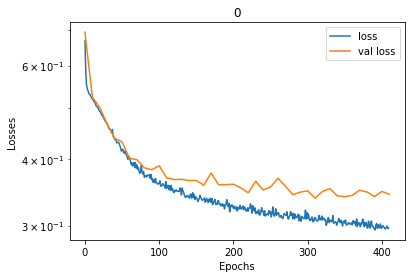

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


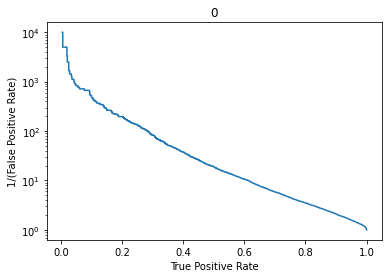

Accuracy of the network: 75 %
ROC AUC: 0.84840106
On layer 1
Starting training...


 56%|█████▌    | 560/1000 [01:07<00:52,  8.33it/s]


INFO: Early stopping
Finished Training


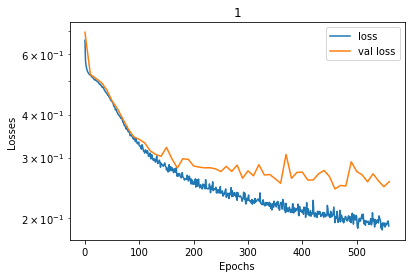

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


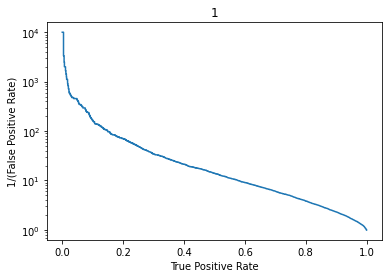

Accuracy of the network: 71 %
ROC AUC: 0.84798552
On layer 2
Starting training...


 17%|█▋        | 170/1000 [00:17<01:23,  9.91it/s]


INFO: Early stopping
Finished Training


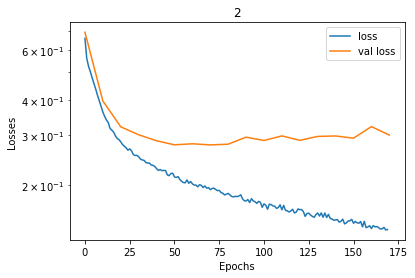

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


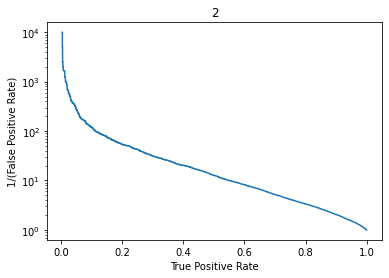

Accuracy of the network: 71 %
ROC AUC: 0.8298362050000001


In [7]:
data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

# print data dimensions
print( "Train data shape: " + str( data_train.shape ), flush=True)
print( "Train labels shape: " + str( labels_train.shape ), flush=True)
print( "Val data shape: " + str( data_val.shape ), flush=True)
print( "Val labels shape: " + str( labels_val.shape ), flush=True)

# Define the NN parameters

full_sup_AUC = {i:0 for i in range(3)}

input_shape = model_dim
num_epochs = 1000
batch_size = 256
update_epochs = 10
lr = 0.001

# Run the NN

for trait in range(sig_reps.shape[1]): # going through the layers of the transformer
    
    print("On layer", trait)

    performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                          data_train[:,trait,:], labels_train, 
                          data_val[:,trait,:], labels_val,
                          STS_reps[:,trait,:], STS_labels, 
                          verbose = True, early_stop = True, LRschedule = False)


    # Plot the output losses   
    plt.figure()
    plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
    plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.yscale("log")
    plt.legend()
    plt.title(trait)
    plt.show()

    plt.figure()
    plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
    plt.yscale("log")
    plt.xlabel("True Positive Rate")
    plt.ylabel("1/(False Positive Rate)")
    plt.title(trait)
    plt.show()

    print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
    print("ROC AUC:", performance_stats["auc"])
    
    full_sup_AUC[trait] = performance_stats["auc"]
    
    


# Testing the classifier (CWoLa)

Starting CWoLa training run with f1 = 0.05
Train data shape: (16000, 3, 128)
Train labels shape: (16000,)
Val data shape: (4000, 3, 128)
Val labels shape: (4000,)
On layer 0


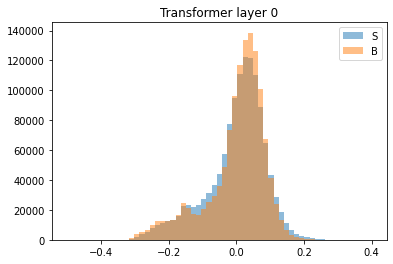

Starting training...


 15%|█▍        | 149/1000 [00:21<02:34,  5.49it/s]

In [ ]:
# Define the NN parameters

input_shape = model_dim
num_epochs = 1000
batch_size = 256
update_epochs = 10
lr = 0.001

visualize = True

f1_vals = []
ROC_AUC_vals = {i:[] for i in range(3)}

for f1 in np.linspace(.05,.95,20):
    
    print("Starting CWoLa training run with f1 =", f1)
    f1_vals.append(f1)
    
    
    # make the datasets / mixed samples
    M1, M2 = generate_mixed_sample(sig_reps, bkg_reps, f1)
    data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

    # print data dimensions
    print( "Train data shape: " + str( data_train.shape ), flush=True)
    print( "Train labels shape: " + str( labels_train.shape ), flush=True)
    print( "Val data shape: " + str( data_val.shape ), flush=True)
    print( "Val labels shape: " + str( labels_val.shape ), flush=True)

    # Run the NN

    for trait in range(sig_reps.shape[1]): # going through the layers of the transformer

        print("On layer", trait)
        
        # visualise the mixed samples
        
        if visualize:

            S = np.reshape(M1[:,trait,:], (M1.shape[0]*M1.shape[2],1))
            B = np.reshape(M2[:,trait,:], (M2.shape[0]*M2.shape[2],1))

            bins = np.linspace(-.5,.4,60)
            plt.figure()
            plt.hist(S, bins, label = "S", alpha = 0.5)
            plt.hist(B, bins, label = "B", alpha = 0.5)
            plt.legend()
            plt.title("Transformer layer "+str(trait))
            plt.show()

        performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              data_train[:,trait,:], labels_train, 
                              data_val[:,trait,:], labels_val,
                              STS_reps[:,trait,:], STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

        if visualize:
            # Plot the output losses   
            plt.figure()
            plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
            plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
            plt.xlabel("Epochs")
            plt.ylabel("Losses")
            plt.yscale("log")
            plt.legend()
            plt.title(trait)
            plt.show()

            plt.figure()
            plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
            plt.yscale("log")
            plt.xlabel("True Positive Rate")
            plt.ylabel("1/(False Positive Rate)")
            plt.title(trait)
            plt.show()

        print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
        print("ROC AUC:", performance_stats["auc"])
        
        ROC_AUC_vals[trait].append(performance_stats["auc"])
        print()




In [ ]:
plt.figure()
for i in range(3):
    plt.scatter(f1_vals,ROC_AUC_vals[i], label = "CWoLa "+str(i))
plt.scatter(f1_vals, np.full(len(f1_vals), full_sup_AUC[i]), label = "Full. Sup.", color = "k")
plt.legend()
plt.xlabel("f1")
plt.ylabel("AUC")
plt.show()